The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

# NTDS assignment 3: spectral graph theory
[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL LTS2](http://lts2.epfl.ch)

In [201]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (17, 5)

# Added 
from bs4 import BeautifulSoup

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [202]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('..', 'credentials.ini'))
api_key = credentials.get('freemusicarchive', 'api_key')

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [203]:
import json
def get_genre(track_id):
    """Returns the genre of a track by querying the API."""
    BASE_URL = "https://freemusicarchive.org/api/get/tracks.xml"
    arguments = {"api_key" : api_key, "track_id" : track_id} # arguments to request is cleaner than url
    response = requests.get(BASE_URL, arguments)
    # Safety first! Tell the user if there was a problem in communication
    assert response.status_code == requests.codes.ok, \
        "Response status is {}, should be {}!".format(response.status_code, requests.codes.ok)
    # Use BeautifulSoup to make our life easy
    cleaned_up_response = BeautifulSoup(response.text, 'html.parser')
    
    # We get the genres of the song (we will drop all but the first)
    genres = []
    for genre in cleaned_up_response.track_genres.children:
        genres.append(int(genre.genre_id.string))
    return genres[0]

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [204]:
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [205]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [206]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [207]:
tracks["genre"] = tracks.apply(lambda row : get_genre(row.name) if row.genre == 0 else row.genre, axis=1)

In [208]:
tracks.head(10)

,genre
track_id,
2,21
5,21
182,27
255,12
256,31
368,89
459,36
574,25
676,21


### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [209]:
tracks.to_csv('../data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [210]:
tracks = pd.read_csv('../data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [211]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(5)

,genre
track_id,
2,21
5,21
182,12
255,12
256,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [212]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [213]:
def get_path(track_id):
    return os.path.join('..', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: ../data/000002.mp3
Duration: 29.98s, 1321967 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [214]:
N_MFCC = 20

def compute_mfcc(track_id):
    """ This function will compute the mfcc sequence of a track id
        It reuses the code provided above to extract the audio data and sample_rate
    """
   # 1. Get the path to the file represented by track_id
    filepath = get_path(track_id)
    
    # 2. Decode the mp3 and load the audio in memory.
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    
    mfcc_sequence = librosa.feature.mfcc(audio, sr=sampling_rate)
    
    return mfcc_sequence
 

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [215]:
features = pd.read_csv('../data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [216]:
for tid in tqdm(tracks.index[:10]):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = np.mean(mfcc, axis=1)
    features.at[tid, ('mfcc', 'std')] = np.std(mfcc, axis=1)
    features.at[tid, ('mfcc', 'skew')] = stats.skew(mfcc, axis=1)
    features.at[tid, ('mfcc', 'kurtosis')] = stats.kurtosis(mfcc, axis=1)
    features.at[tid, ('mfcc', 'median')] = np.median(mfcc, axis=1)
    features.at[tid, ('mfcc', 'min')] = np.min(mfcc, axis=1)
    features.at[tid, ('mfcc', 'max')] = np.max(mfcc, axis=1)

features['mfcc','mean'].head(4)

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.712340,117.759397,-42.334596,38.060242,-23.011659,23.920413,-11.944656,13.687301,-7.294474,4.041134,-4.857005,-1.660614,-6.305957,-2.195009,1.731766,-0.433247,6.396583,-3.303581,1.283125,-5.927941
5,-162.232688,131.441883,-18.427922,51.634278,-15.447669,23.863670,-7.870194,10.688036,-0.314265,12.865315,-9.883394,0.066135,0.767982,2.769372,9.108076,1.641228,8.163592,-1.507941,1.992454,-4.972336
182,-109.799454,220.001599,-82.343022,31.680364,1.788921,-22.898936,25.879739,2.623440,2.484729,14.991756,7.680784,5.321623,10.864427,11.507535,3.471169,7.106788,6.655711,-2.040994,0.930488,2.027291
255,-207.437213,215.440329,-23.797856,20.623633,-5.739169,0.590755,6.398019,-3.267668,-2.143415,-4.535064,-3.603153,-3.754366,0.577303,-3.093996,-3.071847,-0.300081,-2.356464,-0.817920,-1.549295,-4.196416


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

In [217]:
# Your code here.
# Example: features.drop(('mfcc', 'mean'), axis=1, inplace=True)
# TODO

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [218]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute? **Your answer here.** TODO!!

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [219]:
# Implementation of the cosine distance
distances = spatial.distance.squareform(spatial.distance.pdist(features, metric='cosine'))

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

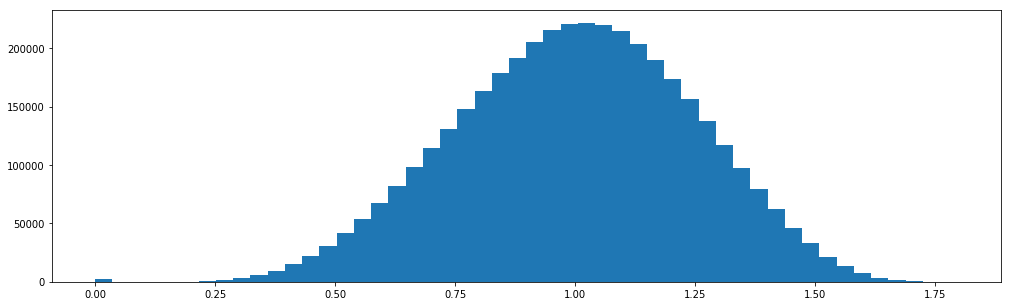

In [220]:
plt.hist(distances.reshape(-1), bins=50);

In [221]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2000 distances equal exactly zero.


*Why are some distances equal to zero?*

We have used the squareform function, which returns a redundant distance matrix from a condensed matrix. Particularly, it returns an array of $N^2$, where N is the number of tracks. The distance from one track to itself is 0, because they are identical. Because of this, the diagonal of the distance matrix contains only zeros. This is why we have 2000 distances that are zero.

TODO: after optimization we might have more zero, explain if this is the case.

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel? **Your answer here.** TODO

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [222]:
kernel_width = distances.mean()
weights = np.exp((-np.square(distances))/kernel_width**2)

# Set the diagonal weights to 0
for index in range(len(weights)):
    weights[index][index] = 0

# Validate that all the weights on the diagonal are null
print(np.sum(np.diagonal(weights)==0))

2000


So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

100%|██████████| 2000/2000 [00:03<00:00, 663.96it/s] 


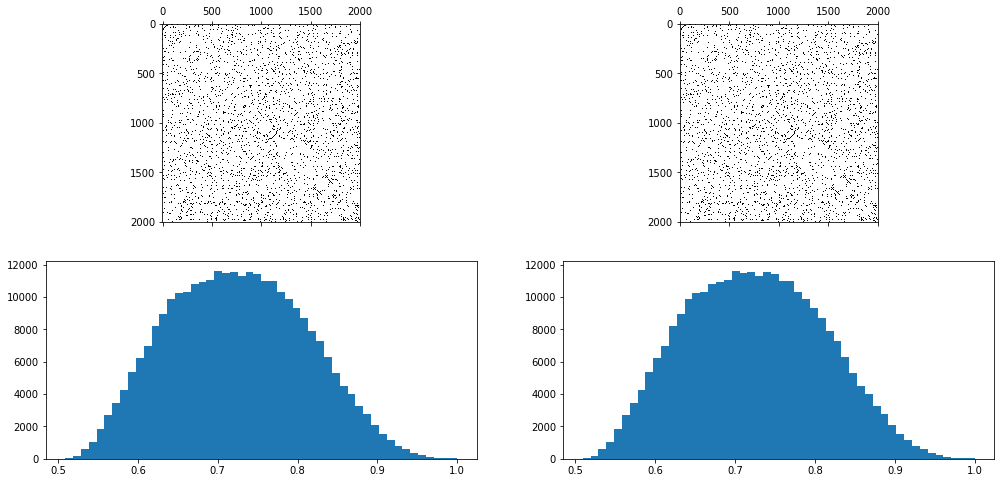

In [238]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 100
sorted_weights_indexes = np.argsort(weights, axis=1)

# Set to zero the weights that are not in the NEIGHBORS
for line in tqdm(range(len(sorted_weights_indexes))):
    for index in range(len(weights[0])-NEIGHBORS):
        weights[line][sorted_weights_indexes[line][index]] = 0
        

for i in tqdm(range(len(weights))):
    # We need to check only the bottom triangle, because we do two checks
    for j in range(i):
        if weights[i][j] == 0 and weights[j][i] != 0:
            weights[i][j] = weights[j][i]
            
        if weights[i][j] != 0 and weights[j][i] == 0:
            weights[j][i] = weights[i][j]
            

plot(weights, axes[:, 1])

In [239]:
# Make sure that weight is symmetric
def check_symmetric(a, tol=1e-10):
    """Function to check if a is symmetric
        taken from: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
    """
    return np.allclose(a, a.T, atol=tol)

assert check_symmetric(weights), "The function is not symmetric!"

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

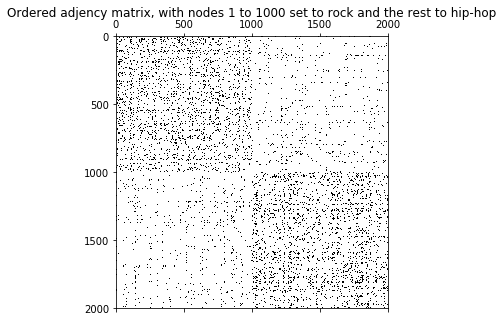

In [240]:
# Reorder the weight matrices, with tracks of first genre from 0 to 1000 and from second genre from 1000 to 2000
# print the reordered weight matrix
# 12 = rock, 21 = hip hop
# TODO: check if this can be done with a cleaner function, maybe from numpy
non_indexed_genre = np.array(tracks['genre'])
tracks_by_genre = np.argsort(non_indexed_genre)
new_row_weights = [weights[index] for index in tracks_by_genre]

reordered_weights=[]
# We if a track goes from 10 to 1, we need to change its row and its column to '1'
# This loop does this by creating a new adjacency matrix to which it appends rows
# The rows values are reordered before behing appended to reorder the columns at the same time
for row in range(len(new_row_weights)):
    row_to_append = [new_row_weights[row][index] for index in tracks_by_genre]
    reordered_weights.append(row_to_append)

plt.title("Ordered adjency matrix, with nodes 1 to 1000 set to rock and the rest to hip-hop")
plt.spy(reordered_weights)
plt.show()

We can clearly see clustering in the upper left and bottom right corner.

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

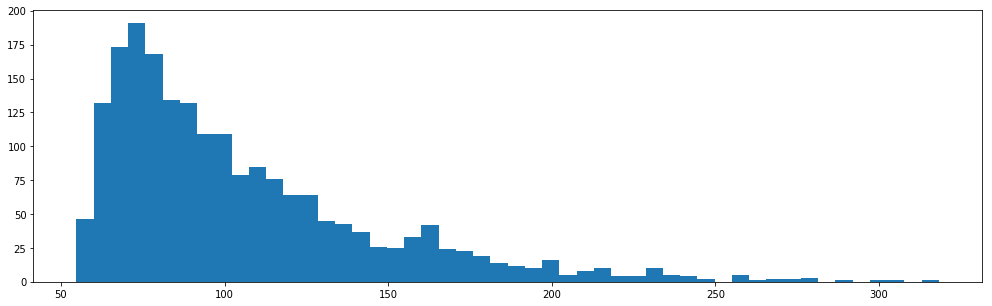

In [241]:
degrees = np.sum(weights, axis=1) 
plt.hist(degrees, bins=50);

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian?

We will compute the normalized Laplacian. To compute the Fieldler value we will need to compute the eigenvalues of the normalized Laplacian. Because of this it is better to compute the normalized Laplacian directly.

Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

In [243]:
laplacian = np.zeros((len(degrees), len(degrees)))
laplacian.flags.writeable = True

import scipy.sparse.csgraph

for i in tqdm(range(len(degrees))):
    for j in range(len(degrees)):
        if i==j:
            laplacian[i][j] = 1
        else:
            laplacian[i][j] = -weights[i][j]/np.sqrt(degrees[i]*degrees[j])
            

100%|██████████| 2000/2000 [00:08<00:00, 223.53it/s]


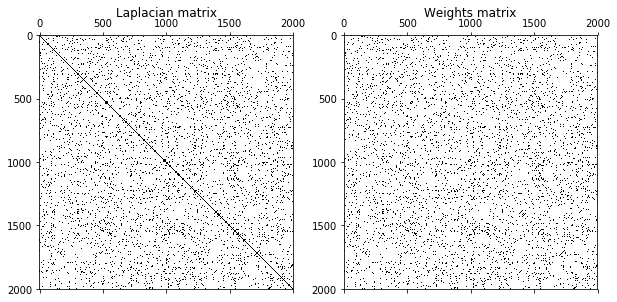

In [244]:
fix, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].spy(laplacian);
axes[0].set_title("Laplacian matrix")
axes[1].spy(weights)
axes[1].set_title("Weights matrix")
plt.show()

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [245]:
laplacian = sparse.csr_matrix(laplacian)

Compute the number of remaining edges in the graph.

In [246]:
# We can use the number of non-zero entries in the matrix
non_zero = laplacian.getnnz()
print("Number of non-zero values is: {}".format(non_zero))

# We need to substract the diagonal from this number and divide it by two, because the matrix is symmetric
# i.e. each edge is represented two times
nbr_remaining_edges = (non_zero - len(weights)) // 2
print("Number of remaining edges is: {}".format(nbr_remaining_edges))

Number of non-zero values is: 292452
Number of remaining edges is: 145226


## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.

Because we have a sparse matrix, we want to use one of the sparse functions. We can see that eigs compute the eigendecomposition for any square matrix, whilst eigsh computes the eigendecomposition of a symmetric matrix.
Because we have a symmetric matrix, the second function is likely more efficient than the first. 

In [248]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10 ,which='SM')

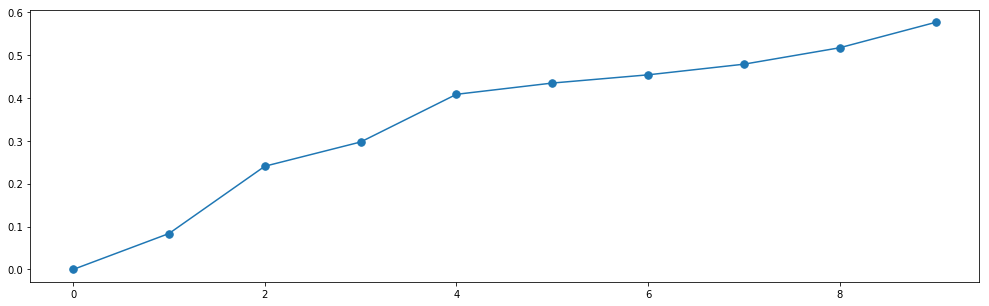

In [249]:
plt.plot(eigenvalues, '.-', markersize=15);

In [263]:
# sanitty check, make sure that the smallest eigenvalue is approximatly zero
epsilon = 1e-16
assert -epsilon < eigenvalues[0] < epsilon, "first eigenvalue isn't 0, it is {}".format(eigenvalues[0])

(We used the fact that the Laplacian is characterized as being: "real, symmetric and PSD")
(From there, we used https://en.wikipedia.org/wiki/Symmetric_matrix, https://en.wikipedia.org/wiki/Positive-definite_matrix#Positive_semidefinite, https://en.wikipedia.org/wiki/Hermitian_matrix to obtain proper definitions)


Why can we diagonalize the graph Laplacian in the first place? Because it is a real symmetric matrix, which are diagonizable by an orthogonal matrix.

Why are all the eigenvalues real? Real symmetric matrices are Hermitian, which implies that all of its eigenvalues are real.

Why are all the eigenvalues non-negative? This arises from the positive semi-definite property of the Laplacian matrix. Indeed, the condition for being positive semi-definite is to have non-negative eigenvalues.

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?

In [257]:
# We validate that the second smallest eigenvalue is not zero. We use the epsilon again because comparing
# float with equality is always a bad idea.
print("Graph Connected, second smallest eigenvalue = {}".format(eigenvalues[1])) if eigenvalues[1] > epsilon \
else print("Graph Not connected, second smallest eigenvalue = {}".format(eigenvalues[1]))

Graph Connected, second smallest eigenvalue = 0.08383052088977976


We can't ensure that the graph is connected. For each nodes, we selected the 100 edges with the higher weights. There's weight distributions that could cause groups of nodes to create a cluster which has no connection to the exterior.

We can prove this by a proof of existence of this type of situation:

If the first 101 nodes of the graph form a complete graph with no outward edges, we would have a separated cluster, which means that the graph wouldn't be connected.

With higher amount of nodes, the same type of situation can occur where an independent cluster gets formed (Though this situation is very unlikely, unless we did a perfect split of the type of music!)

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [258]:
np.sum(laplacian @ (2 * eigenvectors[:, 0]))

-2.8102520310824275e-16

We expect the result of the computation to be zero.

Indeed, we have:

**Multiplication of Laplacian with eigenvector**


$$Av = \lambda_0 v = \textbf{0}$$
Where:
- A is a square matrix
- $\lambda_0$ is the first eigenvalue, is 0 in theory and very close to 0 in practice 
- v is the eigenvector associated with the eigenvalue $\lambda_0$
- $\textbf{0}$ is a column vector with the same length of v, containing only zeros

The result is derived by the fact that a vector multiplied by a scalar of 0 results in a value of zero.

Summing the parts of this vector should lend a value of zero or very close to zero in our case, because the 
first eigenvalue ($\lambda_0$) is not exactly 0

**The multiplication by a scalar**

The scalar multiplication of a matrix is commutative and associative.
Also, the multiplication of matrices is associative.

From those properties we have:

$$A(2*v) = A(v*2) = (Av)*2 = (\lambda_0 v)* 2 = (\textbf{0})*2 = \textbf{0}$$

The sum of this result will also be zero or very close to zero in our case.


## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

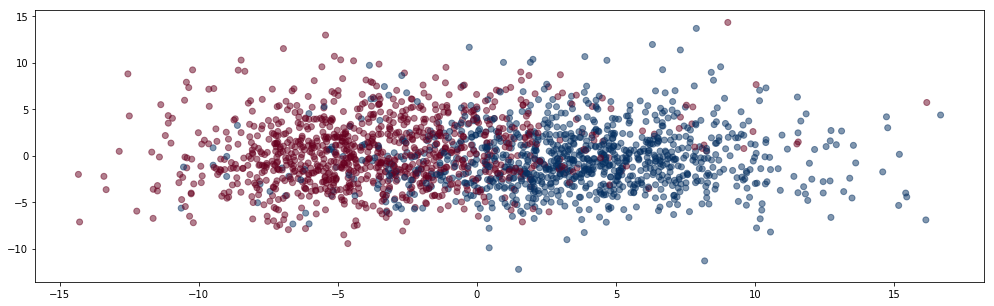

In [293]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)

genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

*Why don't we use the first eigenvector?*

The first eigenvector values are very close to each other. In theory, they would even be identical.

Indeed, the Laplacian satisfies the condition $Lv_0 = \textbf{0}$, where $v_0$ is a uniform vector (all ones for example). 

Because of this, using the first eigenvector values as a coordinate of a node would not give pertinent information. In the theoretical case, all of the associated coordinates would be the same. Because we used a numeric calculation, in our case this isn't true, but we can see from the statistics of the first eigenvector that the values form a tight group together (look at the std particularly), which is the opposite of what we want to visualize our graph.

In [275]:
print(pd.Series(eigenvectors[:, 0]).describe())

count    2000.000000
mean       -0.021989
std         0.004061
min        -0.038886
25%        -0.024213
50%        -0.021040
75%        -0.018806
max        -0.016127
dtype: float64


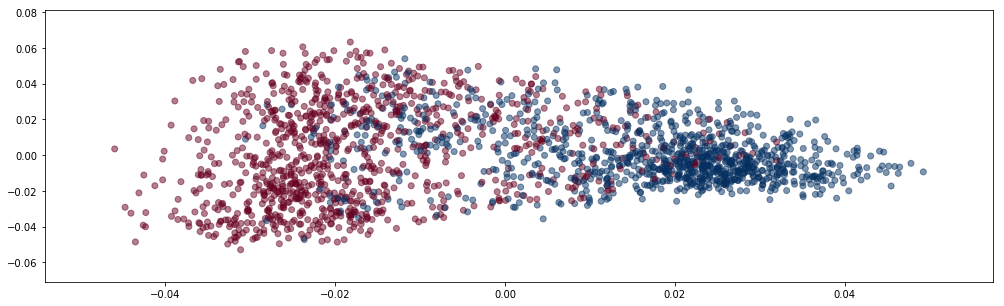

In [311]:
x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);
plt.show()

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?

It tells us that there's clear distinctions between the two genres audio features, which get showed in the resulting graph simply because it is an underlying property of the system under study. In fact, this is a showcase of "natural classification", where the two datasets are sufficiently different to for clusters together without particular learning or classification. Obviously, we can see that there's still some overlaps between tracks of different genre. In the first pass, without optimization, it is mainly in the middle that there's significant overlap. There's clearly some properties that are not distinctive between the groups. In our optimization we will try to remove those properties and obtain a better "natural classification".

TODO: talk after optimization

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

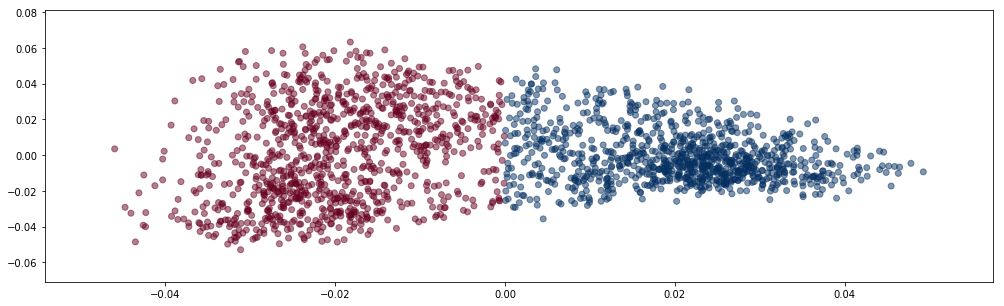

In [312]:
labels = np.sign(eigenvectors[:, 1])

plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [319]:
# The genre is 0 for Rock and 1 for Hip-Hop, we can check the sign of the eigenvectors and compare
# it to what it should be depending on the associated genre
def check_correct_sign(index):
    check_correct_sign_rock = lambda index : np.sign(eigenvectors[index, 1]) == -1
    check_correct_sign_hip_hop = lambda index : np.sign(eigenvectors[index, 1]) == 1
    return check_correct_sign_rock(index) if genres[index] == 0 else check_correct_sign_hip_hop(index)
                                                        
err = np.sum([1 for index in range(len(genres)) if not check_correct_sign(index)])
print('{} errors ({:.2%})'.format(err, err/len(labels)))

321 errors (16.05%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2?

**Your answer here.**